# Panel Forecasting

In earlier tutorials we worked with a single time series. In practice, you will often need to forecast **many related series at once** — sales for every store, demand for every product, traffic at every sensor, etc.

A collection of multiple time series with a flat hierarchy is called a **panel**. Each series shares the same time axis but belongs to a different entity (store, product, sensor, …). sktime represents, as default, panels as a `pandas` DataFrame with a `MultiIndex`: one level identifies the entity, the other identifies time.

This tutorial covers two complementary strategies:

| Strategy | Idea |
|---|---|
| **Local (broadcast)** | Fit one independent model per series | 
| **Global (reduction)** | Fit a single model on all series pooled together | 

We also look at preprocessing considerations specific to panels (scaling, detrending) and how to evaluate forecasts across multiple series.

**Duration:** ~15 minutes

## Learning objectives

By the end of this tutorial, you will be able to:
- Understand the panel data structure in sktime (multi-indexed DataFrames)
- Forecast a panel using local (broadcast) and global (reduction) strategies
- Apply scaling and detrending to prepare panel data for global models
- Combine clustering with global forecasting
- Evaluate forecasts across multiple series using panel-aware metrics

## 1. The panel data structure

sktime uses `pandas` MultiIndex DataFrames to represent panel data. The convention is:

- **Level 0..M** (left-most): identifies the series (entity / instance). This can be a single level (e.g., product ID) or multiple levels (e.g., store ID + product ID).
- **Level -1** (right-most): the time index

Let's load a real-world dataset — the **M5 competition** data — and reshape it into this format. This dataset is hierarchical originally but, for this tutorial, we consider it as a flat panel of store-category series.

In [45]:
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sktime.datasets import load_m5
from sktime.utils.plotting import plot_series

# Download M5 data (first run may take a moment)
data = load_m5("./data")
data = data[["sales"]]

# Aggregate to store × category level for a manageable panel
y = data.reset_index()
y = y.groupby(["store_id", "cat_id", "date"])[["sales"]].sum()
y

sales
store_id cat_id    date             
CA_1     FOODS     2011-01-29   3239
                   2011-01-30   3137
                   2011-01-31   2008
                   2011-02-01   2258
                   2011-02-02   2032
...                              ...
WI_3     HOUSEHOLD 2016-04-20    683
                   2016-04-21    715
                   2016-04-22    867
                   2016-04-23   1033
                   2016-04-24    967

[57390 rows x 1 columns]

Notice the two-level `MultiIndex`: `store`, `category` (entities) and `date` (time). This is all sktime needs to treat the DataFrame as a panel: multiindex with time as the rightmost level.

### 1.1 Quick Pandas MultiIndex refresher

A few operations you will use frequently when working with panel data. Feel free to skip if you are already familiar with these.

*Number of levels:* 

In [46]:
y.index.nlevels

3

*Series in the panel:* 

In [47]:
y.index.droplevel(-1).unique()

MultiIndex([('CA_1',     'FOODS'),
            ('CA_1',   'HOBBIES'),
            ('CA_1', 'HOUSEHOLD'),
            ('CA_2',     'FOODS'),
            ('CA_2',   'HOBBIES'),
            ('CA_2', 'HOUSEHOLD'),
            ('CA_3',     'FOODS'),
            ('CA_3',   'HOBBIES'),
            ('CA_3', 'HOUSEHOLD'),
            ('CA_4',     'FOODS'),
            ('CA_4',   'HOBBIES'),
            ('CA_4', 'HOUSEHOLD'),
            ('TX_1',     'FOODS'),
            ('TX_1',   'HOBBIES'),
            ('TX_1', 'HOUSEHOLD'),
            ('TX_2',     'FOODS'),
            ('TX_2',   'HOBBIES'),
            ('TX_2', 'HOUSEHOLD'),
            ('TX_3',     'FOODS'),
            ('TX_3',   'HOBBIES'),
            ('TX_3', 'HOUSEHOLD'),
            ('WI_1',     'FOODS'),
            ('WI_1',   'HOBBIES'),
            ('WI_1', 'HOUSEHOLD'),
            ('WI_2',     'FOODS'),
            ('WI_2',   'HOBBIES'),
            ('WI_2', 'HOUSEHOLD'),
            ('WI_3',     'FOODS'),
            ('WI_3',

*Unique time points:*

In [48]:
# Dates is a pd.PeriodIndex
dates = y.index.get_level_values(-1).unique()
print(f"\nTime range: {dates.min()} → {dates.max()}")


Time range: 2011-01-29 → 2016-04-24


*Selecting series and dropping outer level* 

In [49]:
# Selecting a single series — .loc drops the outer level
y.loc[("CA_1", "FOODS")].tail()

,sales
date,
2016-04-20,2490
2016-04-21,2533
2016-04-22,2960
2016-04-23,3655
2016-04-24,4053


*Selecting series and keeping outer level*

In [50]:
# Selecting while keeping the MultiIndex — use a list or IndexSlice
y.loc[pd.IndexSlice["CA_1", "FOODS", :], :].tail()

sales
store_id cat_id date             
CA_1     FOODS  2016-04-20   2490
                2016-04-21   2533
                2016-04-22   2960
                2016-04-23   3655
                2016-04-24   4053

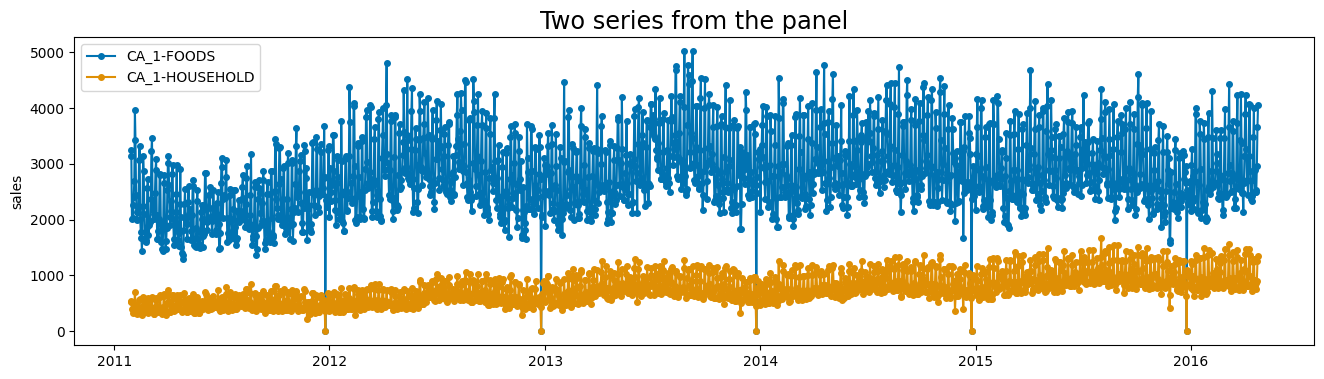

In [51]:
# Visualising two series side by side
plot_series(
    y.loc[("CA_1", "FOODS")],
    y.loc[("CA_1", "HOUSEHOLD")],
    labels=["CA_1-FOODS", "CA_1-HOUSEHOLD"],
    title="Two series from the panel",
)
plt.show()

### 1.2 Train / test split

`temporal_train_test_split` respects the panel structure — it splits each series at the same point in time.

In [52]:
from sktime.split import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, test_size=28)

fh = np.arange(1, 29)  # 28-day forecast horizon

print(f"Train: {len(y_train)} rows  |  Test: {len(y_test)} rows")
y_test.head()

Train: 56550 rows  |  Test: 840 rows


sales
store_id cat_id date             
CA_1     FOODS  2016-03-28   2480
                2016-03-29   2481
                2016-03-30   2135
                2016-03-31   2651
                2016-04-01   3132

## 2. Local forecasting (broadcasting)

The simplest approach: fit one independent model per series. In sktime this requires **zero extra code** — just pass the panel DataFrame to `fit`. Internally, sktime creates one replica of the forecaster for each entity.

In [53]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

model = ExponentialSmoothing(trend="add", seasonal="add")
model.fit(y_train)

y_pred = model.predict(fh=fh)
y_pred

sales
store_id cat_id    date                   
CA_1     FOODS     2016-03-28  2911.356084
                   2016-03-29  2624.355798
                   2016-03-30  2572.872492
                   2016-03-31  2532.407838
                   2016-04-01  2827.877568
...                                    ...
WI_3     HOUSEHOLD 2016-04-20   630.128780
                   2016-04-21   666.940242
                   2016-04-22   802.788946
                   2016-04-23   976.947600
                   2016-04-24   894.354946

[840 rows x 1 columns]

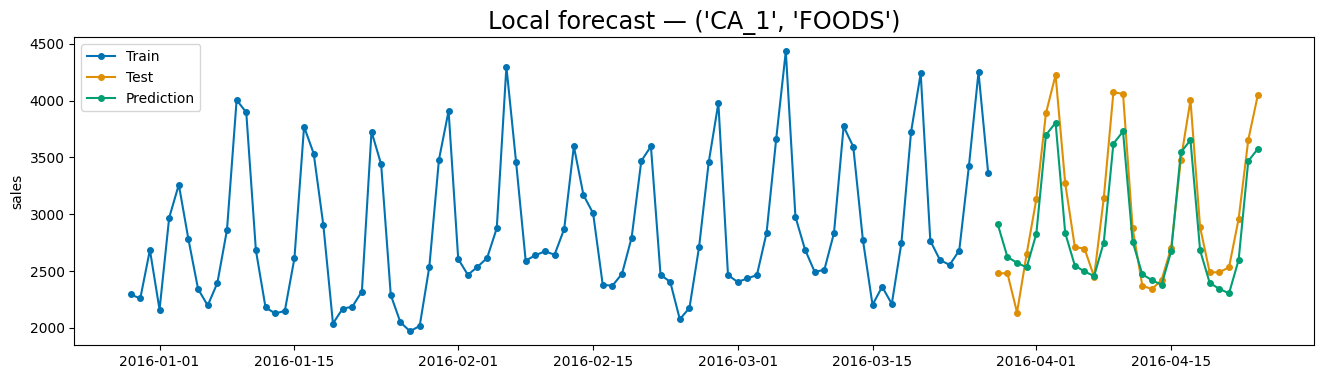

In [54]:
# Visualise predictions for one series
selected_series = ("CA_1", "FOODS")

plot_series(
    y_train.loc[selected_series].tail(90),
    y_test.loc[selected_series],
    y_pred.loc[selected_series],
    labels=["Train", "Test", "Prediction"],
    title=f"Local forecast — {selected_series}",
)
plt.show()

You can inspect the individual fitted models via `get_fitted_params`:

In [55]:
fitted_params = model.get_fitted_params()
fitted_params["forecasters"].head(15)

forecasters
CA_1 FOODS      ExponentialSmoothing(seasonal='add', trend='add')
     HOBBIES    ExponentialSmoothing(seasonal='add', trend='add')
     HOUSEHOLD  ExponentialSmoothing(seasonal='add', trend='add')
CA_2 FOODS      ExponentialSmoothing(seasonal='add', trend='add')
     HOBBIES    ExponentialSmoothing(seasonal='add', trend='add')
     HOUSEHOLD  ExponentialSmoothing(seasonal='add', trend='add')
CA_3 FOODS      ExponentialSmoothing(seasonal='add', trend='add')
     HOBBIES    ExponentialSmoothing(seasonal='add', trend='add')
     HOUSEHOLD  ExponentialSmoothing(seasonal='add', trend='add')
CA_4 FOODS      ExponentialSmoothing(seasonal='add', trend='add')
     HOBBIES    ExponentialSmoothing(seasonal='add', trend='add')
     HOUSEHOLD  ExponentialSmoothing(seasonal='add', trend='add')
TX_1 FOODS      ExponentialSmoothing(seasonal='add', trend='add')
     HOBBIES    ExponentialSmoothing(seasonal='add', trend='add')
     HOUSEHOLD  ExponentialSmoothing(seasonal='add', trend='add')

### 2.1 Parallelisation

Broadcasting is embarrassingly parallel. You can speed it up with a single config call — no code changes required. This works for **any** non-hierarchical forecaster, including custom ones.

In [56]:
parallel_model = ExponentialSmoothing(trend="add", seasonal="add")

# Choose backend: None (loop), "joblib", "dask", or "ray"
parallel_model.set_config(
    backend="joblib",
    backend_params={"n_jobs": -1},  # use all available cores
)

parallel_model.fit(y_train)
y_pred_parallel = parallel_model.predict(fh=fh)
y_pred_parallel

/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:328: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  1 if is_self_iter else self.X_multiindex.groupby(level=iter_levels).ngroups,
/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_utilities.py:317: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=inst_levels, sort=False)
/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:281: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to 

sales
store_id cat_id    date                   
CA_1     FOODS     2016-03-28  2911.356084
                   2016-03-29  2624.355798
                   2016-03-30  2572.872492
                   2016-03-31  2532.407838
                   2016-04-01  2827.877568
...                                    ...
WI_3     HOUSEHOLD 2016-04-20   630.128780
                   2016-04-21   666.940242
                   2016-04-22   802.788946
                   2016-04-23   976.947600
                   2016-04-24   894.354946

[840 rows x 1 columns]

## 3. Global forecasting (reduction)

Instead of fitting one model per series, a **global** forecaster pools all series together and fits a single model. The intuition is that shared patterns (day-of-week effects, promotions, trend shapes) can be learned more efficiently from the combined data. This usually is the best-performing strategy for large panels.

The recipe has two ingredients:

1. **Feature engineering** — `WindowSummarizer` turns time series into a tabular set of lag / rolling features.
2. **Reduction** — `make_reduction` wraps any scikit-learn regressor as a forecaster, with a `pooling="global"` option to train on all series at once.

### 3.1 Feature engineering with WindowSummarizer

In [57]:
from sktime.transformations.series.summarize import WindowSummarizer

window_summarizer = WindowSummarizer(lag_feature={"lag": list(range(1, 35))})

# The transformer respects the panel structure — lags never leak across series
window_summarizer.fit_transform(y)

/Users/felipeangelim/Workspace/sktime/sktime/transformations/series/summarize.py:342: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_grouped = X.groupby(level=hier_levels)[cols]


sales_lag_1  sales_lag_2  sales_lag_3  \
store_id cat_id    date                                                
CA_1     FOODS     2011-01-29          NaN          NaN          NaN   
                   2011-01-30       3239.0          NaN          NaN   
                   2011-01-31       3137.0       3239.0          NaN   
                   2011-02-01       2008.0       3137.0       3239.0   
                   2011-02-02       2258.0       2008.0       3137.0   
...                                    ...          ...          ...   
WI_3     HOUSEHOLD 2016-04-20        678.0        770.0       1003.0   
                   2016-04-21        683.0        678.0        770.0   
                   2016-04-22        715.0        683.0        678.0   
                   2016-04-23        867.0        715.0        683.0   
                   2016-04-24       1033.0        867.0        715.0   

                               sales_lag_4  sales_lag_5  sales_lag_6  \
store_id cat_id    date                                                
CA_1     FOODS     2011-01-29          NaN          NaN          NaN   
                   2011-01-30          NaN          NaN          NaN   
                   2011-01-31          NaN          NaN          NaN   
                   2011-02-01          NaN          NaN          NaN   
                   2011-02-02       3239.0          NaN          NaN   
...                                    ...          ...          ...   
WI_3     HOUSEHOLD 2016-04-20        887.0        845.0        599.0   
                   2016-04-21       1003.0        887.0        845.0   
                   2016-04-22        770.0       1003.0        887.0   
                   2016-04-23        678.0        770.0       1003.0   
                   2016-04-24        683.0        678.0        770.0   

                               sales_lag_7  sales_lag_8  sales_lag_9  \
store_id cat_id    date                                                
CA_1     FOODS     2011-01-29          NaN          NaN          NaN   
                   2011-01-30          NaN          NaN          NaN   
                   2011-01-31          NaN          NaN          NaN   
                   2011-02-01          NaN          NaN          NaN   
                   2011-02-02          NaN          NaN          NaN   
...                                    ...          ...          ...   
WI_3     HOUSEHOLD 2016-04-20        506.0        661.0        753.0   
                   2016-04-21        599.0        506.0        661.0   
                   2016-04-22        845.0        599.0        506.0   
                   2016-04-23        887.0        845.0        599.0   
                   2016-04-24       1003.0        887.0        845.0   

                               sales_lag_10  ...  sales_lag_25  sales_lag_26  \
store_id cat_id    date                      ...                               
CA_1     FOODS     2011-01-29           NaN  ...           NaN           NaN   
                   2011-01-30           NaN  ...           NaN           NaN   
                   2011-01-31           NaN  ...           NaN           NaN   
                   2011-02-01           NaN  ...           NaN           NaN   
                   2011-02-02           NaN  ...           NaN           NaN   
...                                     ...  ...           ...           ...   
WI_3     HOUSEHOLD 2016-04-20        1053.0  ...        1022.0         918.0   
                   2016-04-21         753.0  ...         863.0        1022.0   
                   2016-04-22         661.0  ...         725.0         863.0   
                   2016-04-23         506.0  ...         696.0         725.0   
                   2016-04-24         599.0  ...         639.0         696.0   

                               sales_lag_27  sales_lag_28  sales_lag_29  \
store_id cat_id    date                                                   
CA_1     FOODS     2011-01-29

Note that the NaNs at the start of the series are expected — they correspond to the first few rows where lag features cannot be computed. The `WindowSummarizer` does not drop them automatically, since some global models can handle NaNs internally (e.g., LightGBM).

### 3.2 Why scaling / detrending matters

A global model sees rows from all series during training. If the series live on very different scales, a regressor (especially tree-based) may overfit to level differences instead of learning transferable temporal patterns.

Let's visualise the problem:

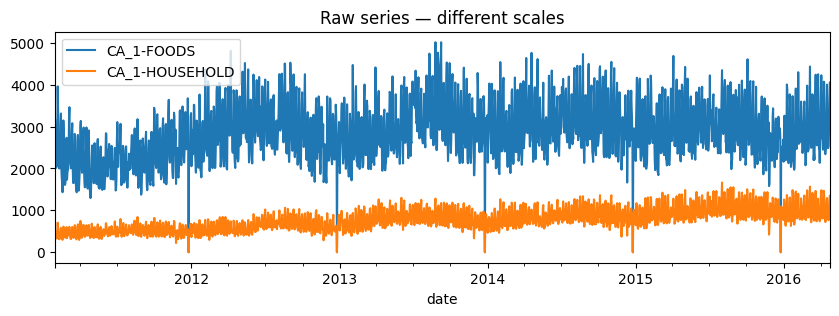

In [58]:
# Raw series live on different scales
fig, ax = plt.subplots(figsize=(10, 3))
y.loc[("CA_1", "FOODS")].sales.plot.line(ax=ax, label="CA_1-FOODS")
y.loc[("CA_1", "HOUSEHOLD")].sales.plot.line(ax=ax, label="CA_1-HOUSEHOLD")
ax.set_title("Raw series — different scales")
ax.legend()
plt.show()

Three common remedies — each works out-of-the-box on panels (applied per series automatically):

| Technique | Effect |
|---|---|
| **Detrending** | Removes the linear trend from each series |
| **Differencing** | Removes the level; resulting series fluctuate around zero |
| **Scaling** | Maps each series to a common range (e.g., 0–1) |

/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:328: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  1 if is_self_iter else self.X_multiindex.groupby(level=iter_levels).ngroups,
/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_utilities.py:317: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=inst_levels, sort=False)
/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:281: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to 

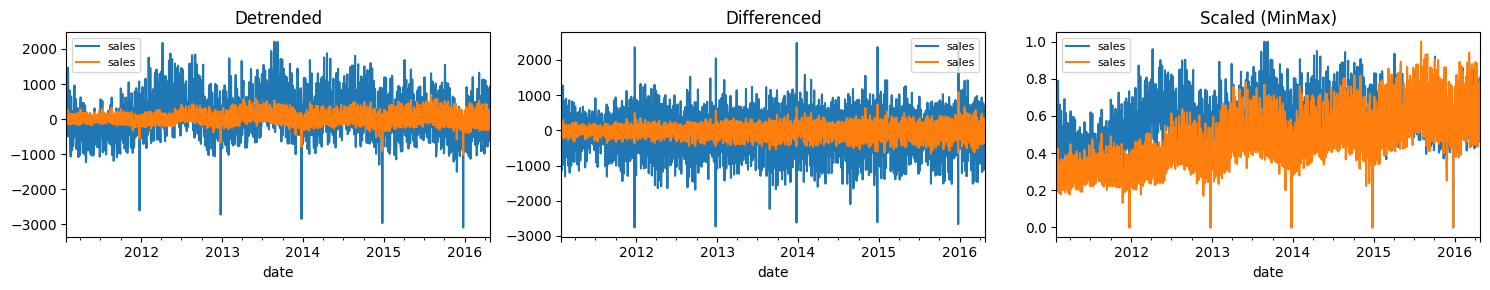

In [59]:
from sklearn.preprocessing import MinMaxScaler

from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.difference import Differencer

fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharey=False)

for ax, (name, transformer) in zip(
    axes,
    [
        ("Detrended", Detrender()),
        ("Differenced", Differencer()),
        ("Scaled (MinMax)", TabularToSeriesAdaptor(MinMaxScaler())),
    ],
):
    y_t = transformer.fit_transform(y)
    y_t.loc[("CA_1", "FOODS")].plot.line(ax=ax, label="CA_1-FOODS")
    y_t.loc[("CA_1", "HOUSEHOLD")].plot.line(ax=ax, label="CA_1-HOUSEHOLD")
    ax.set_title(name)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

With these transformations, although there are still some differences, remove rough level differences and make the series more comparable for a global model.

### 3.3 Building a global forecaster

We use `make_reduction` with `pooling="global"` to create a single regression model that learns from all series jointly. We also chain a scaler in front using the `*` pipeline operator so that the inverse transform is applied automatically at prediction time.

In [60]:
from sklearn.ensemble import GradientBoostingRegressor

from sktime.forecasting.compose import make_reduction

# Core global forecaster: gradient boosting with lag features
global_forecaster = make_reduction(
    GradientBoostingRegressor(),
    transformers=[window_summarizer],
    window_length=None,  # inferred from WindowSummarizer
    strategy="recursive",
    pooling="global",
)

# Wrap with per-series MinMax scaling (fit per series, inverse at predict)
scaler = TabularToSeriesAdaptor(MinMaxScaler())
scaled_global_forecaster = scaler * global_forecaster

scaled_global_forecaster

TransformedTargetForecaster(steps=[TabularToSeriesAdaptor(transformer=MinMaxScaler()),
                                   RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor(),
                                                                        pooling='global',
                                                                        transformers=[WindowSummarizer(lag_feature={'lag': [1,
                                                                                                                            2,
                                                                                                                            3,
                                                                                                                            4,
                                                                                                                            5,
                                                                                                                            6,
                                                                                                                            7,
                                                                                                                            8,
                                                                                                                            9,
                                                                                                                            10,
                                                                                                                            11,
                                                                                                                            12,
                                                                                                                            13,
                                                                                                                            14,
                                                                                                                            15,
                                                                                                                            16,
                                                                                                                            17,
                                                                                                                            18,
                                                                                                                            19,
                                                                                                                            20,
                                                                                                                            21,
                                                                                                                            22,
                                                                                                                            23,
                                                                                                                            24,
                                                                                                                            25,
                                                                                                                            26,
                                                                                                                            27,
                                                                                                                            28,
                                                                                                                            29,
         

In [61]:
# Fit both — with and without scaling — for comparison
scaled_global_forecaster.fit(y=y_train, fh=fh)
global_forecaster.fit(y=y_train, fh=fh)

y_pred_scaled_global = scaled_global_forecaster.predict(fh=fh)
y_pred_global = global_forecaster.predict(fh=fh)

/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_utilities.py:317: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=inst_levels, sort=False)
/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:328: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  1 if is_self_iter else self.X_multiindex.groupby(level=iter_levels).ngroups,
/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:281: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to 

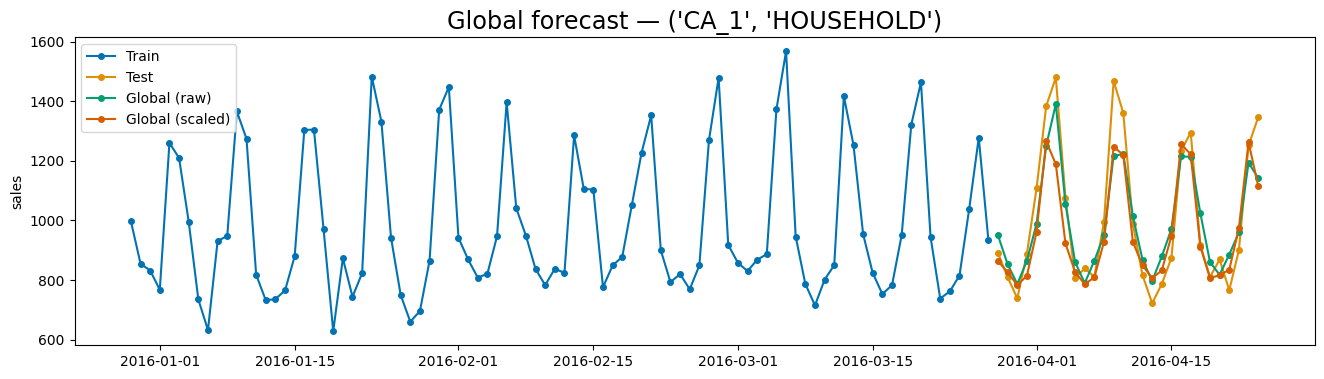

In [62]:
selected_series = ("CA_1", "HOUSEHOLD")

plot_series(
    y_train.loc[selected_series].tail(90),
    y_test.loc[selected_series],
    y_pred_global.loc[selected_series],
    y_pred_scaled_global.loc[selected_series],
    labels=["Train", "Test", "Global (raw)", "Global (scaled)"],
    title=f"Global forecast — {selected_series}",
)
plt.show()

## 4. Clustering + global forecasting

Not all series behave the same. Some are smooth, others are intermittent (mostly zeros with occasional spikes). Grouping similar series and fitting a specialised model per group can combine the best of both local and global worlds.

sktime provides:

- `ADICVTransformer` — classifies each series as *smooth*, *erratic*, *intermittent*, or *lumpy* based on the ADI-CV framework.
- `GroupbyCategoryForecaster` — routes each series to a different forecaster based on its category.

### 4.1 Classifying series

In [63]:
from sktime.transformations.series.adi_cv import ADICVTransformer

categories = ADICVTransformer(["class"], cv_threshold=0.1).fit_transform(y_train)
categories["class"].value_counts()

/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:328: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  1 if is_self_iter else self.X_multiindex.groupby(level=iter_levels).ngroups,
/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:281: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in self.X_multiindex.groupby(level=iter_levels, sort=False):
/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:281: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain 

class
smooth     20
erratic    10
Name: count, dtype: int64

### 4.2 Routing series to specialised forecasters

We assign the scaled global forecaster to smooth/erratic/lumpy categories, and a `Croston` model (designed for intermittent demand) to intermittent series.

In [64]:
from sktime.forecasting.compose import GroupbyCategoryForecaster
from sktime.forecasting.croston import Croston

groupby_forecaster = GroupbyCategoryForecaster(
    {
        "smooth": scaled_global_forecaster,
        "erratic": scaled_global_forecaster,
        "lumpy": scaled_global_forecaster,
        "intermittent": Croston(),
    },
    transformer=ADICVTransformer(["class"]),
)

groupby_forecaster.fit(y_train, fh=fh)
y_pred_groupby = groupby_forecaster.predict(fh=fh)
y_pred_groupby

/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_utilities.py:317: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=inst_levels, sort=False)
/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:328: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  1 if is_self_iter else self.X_multiindex.groupby(level=iter_levels).ngroups,
/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:281: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to 

sales
store_id cat_id    date                   
CA_1     FOODS     2016-03-28  2769.324823
                   2016-03-29  2576.617717
                   2016-03-30  2476.091368
                   2016-03-31  2526.014724
                   2016-04-01  2971.329153
...                                    ...
WI_3     HOUSEHOLD 2016-04-20   608.439934
                   2016-04-21   627.871981
                   2016-04-22   810.347601
                   2016-04-23  1021.222692
                   2016-04-24   956.054464

[840 rows x 1 columns]

## 5. Evaluating panel forecasts

Standard metrics apply, but with panels we must decide **how to aggregate across series**. sktime metrics support a `multilevel` parameter:

| Value | Behaviour |
|---|---|
| `"uniform_average"` | Compute the metric per series, then average across series (default) |
| `"uniform_average_time"` | Pool all data and compute a single metric (ignores series identity) |
| `"raw_values"` | Return the metric per series — useful for spotting outliers |

For some metrics, the `uniform_average` and `uniform_average_time` options will give the same result.

In [65]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

# Single number - computed per series, then averaged across series
mape_avg = MeanAbsolutePercentageError(multilevel="uniform_average")
print("MAPE (avg across series):", round(mape_avg(y_test, y_pred), 4))

# Single number — pool all data
mape_pool = MeanAbsolutePercentageError(multilevel="uniform_average_time")
print("MAPE (pooled):", round(mape_pool(y_test, y_pred), 4))

MAPE (avg across series): 0.1081
MAPE (pooled): 0.1081


/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:328: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  1 if is_self_iter else self.X_multiindex.groupby(level=iter_levels).ngroups,
/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:281: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in self.X_multiindex.groupby(level=iter_levels, sort=False):


In [66]:
# Per-series breakdown
mape_raw = MeanAbsolutePercentageError(multilevel="raw_values")
mape_raw(y_test, y_pred)

/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:328: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  1 if is_self_iter else self.X_multiindex.groupby(level=iter_levels).ngroups,
/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:281: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in self.X_multiindex.groupby(level=iter_levels, sort=False):


MeanAbsolutePercentageError
CA_1 FOODS                         0.075497
     HOBBIES                       0.139117
     HOUSEHOLD                     0.063010
CA_2 FOODS                         0.057170
     HOBBIES                       0.133175
     HOUSEHOLD                     0.108036
CA_3 FOODS                         0.118568
     HOBBIES                       0.092009
     HOUSEHOLD                     0.061770
CA_4 FOODS                         0.069288
     HOBBIES                       0.117038
     HOUSEHOLD                     0.077938
TX_1 FOODS                         0.120312
     HOBBIES                       0.131029
     HOUSEHOLD                     0.090913
TX_2 FOODS                         0.097557
     HOBBIES                       0.099854
     HOUSEHOLD                     0.073762
TX_3 FOODS                         0.097408
     HOBBIES                       0.099343
     HOUSEHOLD                     0.096793
WI_1 FOODS                         0.080282
     HOBBIES                       0.101233
     HOUSEHOLD                     0.112290
WI_2 FOODS                         0.260676
     HOBBIES                       0.130185
     HOUSEHOLD                     0.140686
WI_3 FOODS                         0.118162
     HOBBIES                       0.171660
     HOUSEHOLD                     0.107255

### 5.1 Comparing all strategies

Let's bring everything together and compare the approaches we built in this tutorial.

In [67]:
# Also fit a "local" version of the global forecaster for comparison
from sktime.forecasting.compose import ForecastByLevel

local_gb = ForecastByLevel(global_forecaster, groupby="local")
local_gb_pipeline = scaler * local_gb
local_gb_pipeline.fit(y=y_train)
y_pred_local_gb = local_gb_pipeline.predict(fh=fh)

/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_utilities.py:317: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=inst_levels, sort=False)
/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:328: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  1 if is_self_iter else self.X_multiindex.groupby(level=iter_levels).ngroups,
/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:281: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to 

In [68]:
metric_per_series = MeanAbsolutePercentageError(multilevel="raw_values")

results = {
    "Exp. Smoothing (local)": metric_per_series(y_test, y_pred, y_train=y_train),
    "Global GB (raw)": metric_per_series(
        y_test, y_pred_global.set_index(y_test.index), y_train=y_train
    ),
    "Global GB (scaled)": metric_per_series(
        y_test, y_pred_scaled_global.set_index(y_test.index), y_train=y_train
    ),
    "Groupby Global": metric_per_series(
        y_test, y_pred_groupby.set_index(y_test.index), y_train=y_train
    ),
    "Local GB": metric_per_series(
        y_test, y_pred_local_gb.set_index(y_test.index), y_train=y_train
    ),
}

# Build comparison table
comparison = pd.concat([v.squeeze().rename(k) for k, v in results.items()], axis=1)
comparison.loc["Mean"] = comparison.mean()
comparison

/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:328: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  1 if is_self_iter else self.X_multiindex.groupby(level=iter_levels).ngroups,
/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:328: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  1 if is_self_iter else self.X_multiindex.groupby(level=iter_levels).ngroups,
/Users/felipeangelim/Workspace/sktime/sktime/datatypes/_vectorize.py:281: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain 

,Exp. Smoothing (local),Global GB (raw),Global GB (scaled),Groupby Global,Local GB
"(CA_1, FOODS)",0.075497,0.057254,0.060274,0.060274,0.048186
"(CA_1, HOBBIES)",0.139117,0.153698,0.152869,0.152869,0.138202
"(CA_1, HOUSEHOLD)",0.063010,0.077302,0.072065,0.072065,0.069531
"(CA_2, FOODS)",0.057170,0.101022,0.110330,0.110330,0.121372
"(CA_2, HOBBIES)",0.133175,0.141877,0.152585,0.152585,0.139011
"(CA_2, HOUSEHOLD)",0.108036,0.126759,0.128640,0.128640,0.133714
"(CA_3, FOODS)",0.118568,0.087225,0.072911,0.072911,0.060370
"(CA_3, HOBBIES)",0.092009,0.129814,0.107049,0.107049,0.111993
"(CA_3, HOUSEHOLD)",0.061770,0.068092,0.057867,0.057867,0.071955
"(CA_4, FOODS)",0.069288,0.056146,0.047396,0.047396,0.053141


## Key takeaways

* **Panel = MultiIndex DataFrame** — entity level(s) + time level. That's all sktime needs.
* **Local forecasting** requires zero extra code: pass the panel to any forecaster and sktime broadcasts it automatically. Parallelisation is a one-liner.
* **Global forecasting** pools series via `make_reduction(pooling="global")`. Pair it with `WindowSummarizer` for lag/rolling features and a scikit-learn regressor.
* **Scale and detrend** before training a global model — the series should be comparable for the regressor to learn transferable patterns.
* **Cluster + route** with `GroupbyCategoryForecaster` to assign specialised models to different series types.
* **Panel metrics** support `multilevel` for flexible aggregation — average, pool, or per-series breakdowns.

### Next

Proceed to the **hierarchical forecasting** tutorial to learn about aggregation constraints and reconciliation methods.

## References

[1] Montero-Manso, P. and Hyndman, R.J. (2021). "Principles and algorithms for forecasting groups of time series: Locality and globality." *International Journal of Forecasting*, 37(4), 1632–1653.

[2] Makridakis, S., Spiliotis, E. and Assimakopoulos, V. (2022). "M5 accuracy competition: Results, findings, and conclusions." *International Journal of Forecasting*, 38(4), 1346–1364.

[3] Semenoglou, A.-A. et al. (2021). "Investigating the accuracy of cross-learning time series forecasting methods." *International Journal of Forecasting*, 37(3), 1072–1084.